## Parameter recovery summary

We were able to simulate data, estimate parameters using BHM and MLE. No we want to make some summary plots to evaluate each method.

In [112]:
# Built-in/Generic Imports
import os,sys
import glob
import math

# Libs
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.display.max_rows = 999

### BHM heatmaps

In [113]:
def heatmap_save(df,model='bhm',type='sing'):
    for v in ['kappa','gamma']:
        for err in ['mse','nmse']:
            err_col = '{}_{}_{}'.format(v,type,err)
            fig_fn = 'simul/img/{}/{}_{}_{}.png'.format(err,v,model,type)
            if len(type)==0:
                fig_fn='simul/img/{}/{}_{}.png'.format(err,v,model)
                err_col = '{}_{}_{}'.format(v,model,err)
            mse = df[err_col].values.reshape(10,10)
            index = np.round(np.log(df['kappa_gt'].unique()),2)
            columns = np.round(df['gamma_gt'].unique(),2)
            mse_df = pd.DataFrame(mse,index=index,columns=columns)

            fig,ax = plt.subplots(figsize=(15,10))
            fmt = '.1f'
            if err == 'mse':
                s=sns.heatmap(mse_df,annot=True,fmt=fmt,ax=ax)
            elif err == 'nmse':
                fmt = '.1f'
                # vmin vmax values to anchor the colormap
                s=sns.heatmap(mse_df,annot=True,fmt=fmt,ax=ax,vmin=0,vmax=100)
            s.set(xlabel='gamma', ylabel='log kappa')
            ax.set_title('{} {} {} {}'.format(err,model.upper(),type,v))
            fig.savefig(fig_fn)


In [114]:
def get_bhm_df():
    bhm_fn = os.path.join('simul/parameter_estimate_bhm.csv')
    bhm_df = pd.read_csv(bhm_fn,index_col=0)

    for v in ['kappa','gamma']:
        for type in ['sing','agg']:
            bhm_df['{}_{}_mse'.format(v,type)] = (bhm_df['{}_bhm_{}'.format(v,type)]-bhm_df['{}_gt'.format(v)])**2
            # bhm_df['{}_{}_nmse'.format(v,type)] = 100*(bhm_df['{}_bhm_{}'.format(v,type)]-bhm_df['{}_gt'.format(v)])**2 / (bhm_df['{}_bhm_{}'.format(v,type)])**2
            bhm_df['{}_{}_nmse'.format(v,type)] = 100*(bhm_df['{}_bhm_{}'.format(v,type)]-bhm_df['{}_gt'.format(v)])**2 / (bhm_df['{}_gt'.format(v)])**2
    return bhm_df


In [115]:
def get_mle_df(bhm_df):
    mle_fn = os.path.join('simul/utility/split_CDD_analysis.csv')
    df = pd.read_csv(mle_fn,index_col=0)
    mle_df = bhm_df[['kappa_gt','gamma_gt']].copy()
    mle_df['kappa_mle'] = df['kappa']
    mle_df['gamma_mle'] = df['gamma']
    # return mle_df
    for v in ['kappa','gamma']:
        mle_df['{}_mle_mse'.format(v)] = (mle_df['{}_mle'.format(v)]-mle_df['{}_gt'.format(v)])**2
        # mle_df['{}_mle_nmse'.format(v)] = 100*(mle_df['{}_mle'.format(v)]-mle_df['{}_gt'.format(v)])**2 / (mle_df['{}_mle'.format(v)])**2
        mle_df['{}_mle_nmse'.format(v)] = 100*(mle_df['{}_mle'.format(v)]-mle_df['{}_gt'.format(v)])**2 / (mle_df['{}_gt'.format(v)])**2
    return mle_df

In [116]:
def scatter_one(df,v='',err='',x='sing',y='agg'):
    ycol = '{}_{}_{}'.format(v,y,err)
    xcol = '{}_{}_{}'.format(v,x,err)
    fig,ax = plt.subplots(figsize=(6,4))
    s=sns.scatterplot(data=df,x=xcol,y=ycol,ax=ax)
    s.set(xlabel=x, ylabel=y)
    min_val = np.min([np.min(df[ycol]),np.min(df[xcol])])
    max_val = np.max([np.max(df[ycol]),np.max(df[xcol])])
    plt.plot([min_val, max_val],[min_val, max_val],'k-')
    title = '{} {}:{} versus {}'.format(v,err,y,x)
    ax.set_title(title)
    fig_fn = 'simul/img/scatter/{}_{}_{}_vs_{}.png'.format(v,err,y,x)
    fig.savefig(fig_fn)

def scatter_mse(df):
    print(list(df))
    for v in ['kappa','gamma']:
        for err in ['mse','nmse']:
            # agg versus sing
            scatter_one(df,v=v,err=err,x='sing',y='agg')
            # agg versus MLE
            scatter_one(df,v=v,err=err,x='mle',y='agg')
            # sing versus MLE
            scatter_one(df,v=v,err=err,x='mle',y='sing')


In [117]:
def scatter_plot(df,model='bhm',type='sing'):
    for v in ['kappa','gamma']:
        gt_col = '{}_gt'.format(v)
        model_col = '{}_{}_{}'.format(v,model,type)
        ylabel = '{} {} {}'.format(v,model,type)
        xlabel = '{} ground truth'.format(v)
        title = '{} {} {}'.format(model.upper(),type,v)
        fig_fn = 'simul/img/scatter/{}_{}_{}.png'.format(v,model,type)
        if len(type)==0:
            model_col = '{}_{}'.format(v,model)
            ylabel = '{} {}'.format(model,v)
            title = '{} {}'.format(model.upper(),v)
            fig_fn = 'simul/img/scatter/{}_{}.png'.format(v,model)

        fig,ax = plt.subplots(figsize=(8,6))
        s=sns.scatterplot(data=df,x=gt_col,y=model_col,ax=ax)

        min_val = np.min([np.min(df[model_col]),np.min(df[gt_col])])
        max_val = np.max([np.max(df[model_col]),np.max(df[gt_col])])
        plt.plot([min_val, max_val],[min_val, max_val],'k-')
        
        if 'kappa' in v:
            plt.xscale('log')
            plt.yscale('log')
            xlabel = 'log {}'.format(xlabel)
            ylabel = 'log {}'.format(ylabel)
        s.set(xlabel=xlabel, ylabel=ylabel)
        ax.set_title(title)
        fig.savefig(fig_fn)


In [118]:
# MLE bounds: gk_bounds = ((0,8),(0.0022,7.875)) logk = (-6.12,2.06)
print(np.exp(-5))
print(np.log([0.0022,7.875]))

0.006737946999085467
[-6.11929792  2.06369318]


['kappa_gt', 'gamma_gt', 'kappa_bhm_sing', 'gamma_bhm_sing', 'kappa_bhm_agg', 'gamma_bhm_agg', 'kappa_sing_mse', 'kappa_sing_nmse', 'kappa_agg_mse', 'kappa_agg_nmse', 'gamma_sing_mse', 'gamma_sing_nmse', 'gamma_agg_mse', 'gamma_agg_nmse', 'kappa_gt', 'gamma_gt', 'kappa_mle', 'gamma_mle', 'kappa_mle_mse', 'kappa_mle_nmse', 'gamma_mle_mse', 'gamma_mle_nmse']


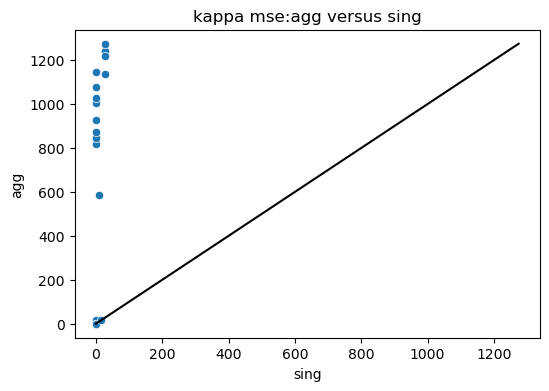

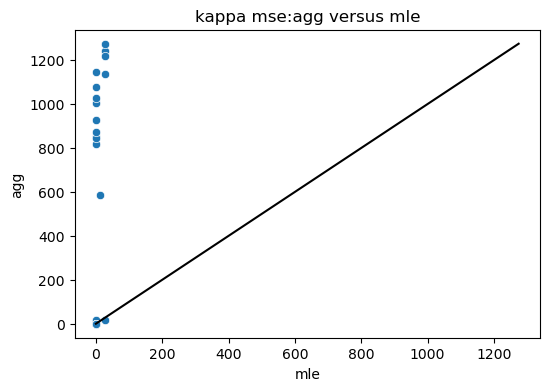

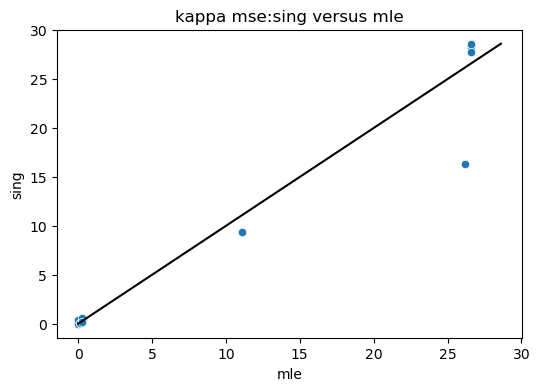

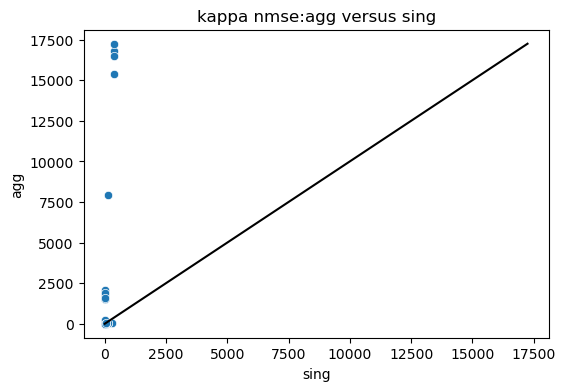

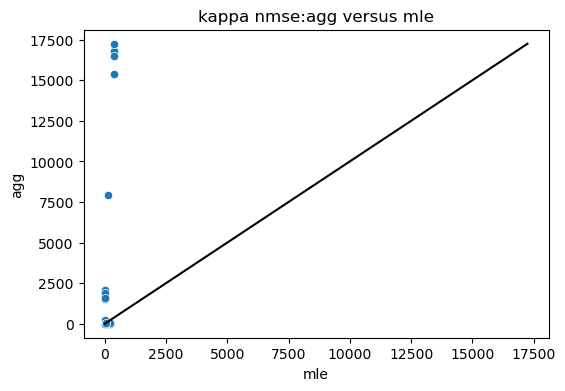

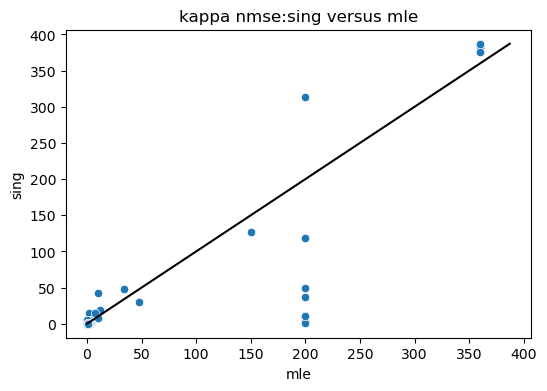

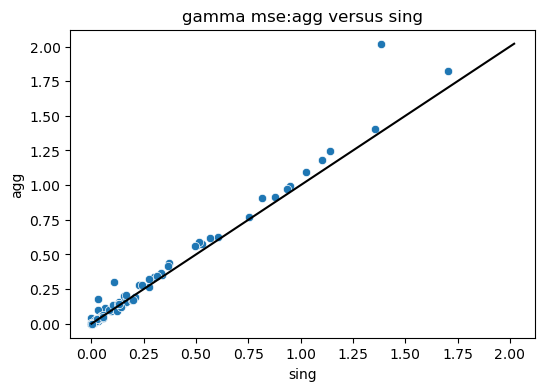

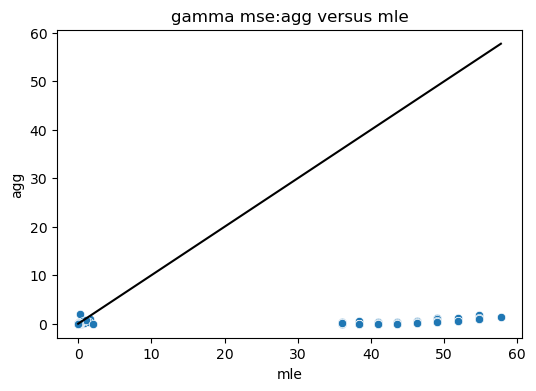

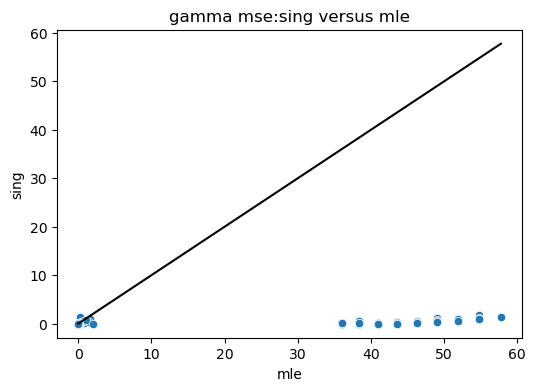

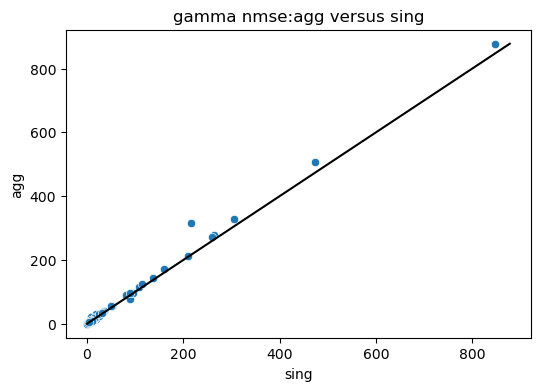

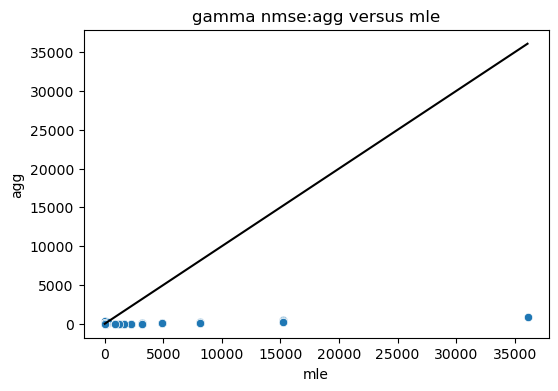

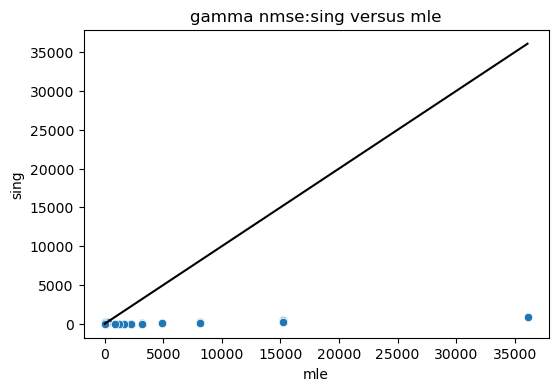

In [119]:
bhm_df = get_bhm_df()
mle_df = get_mle_df(bhm_df)
df = pd.concat([bhm_df,mle_df],axis=1)
scatter_mse(df)


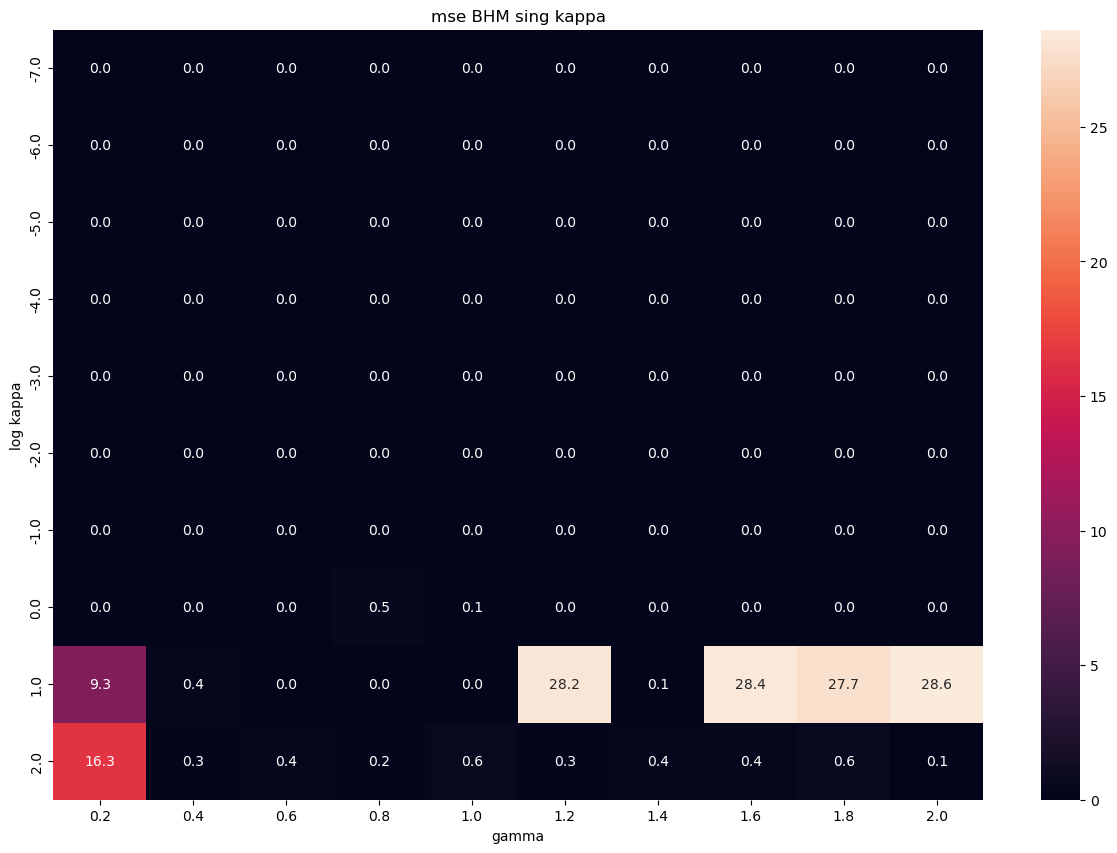

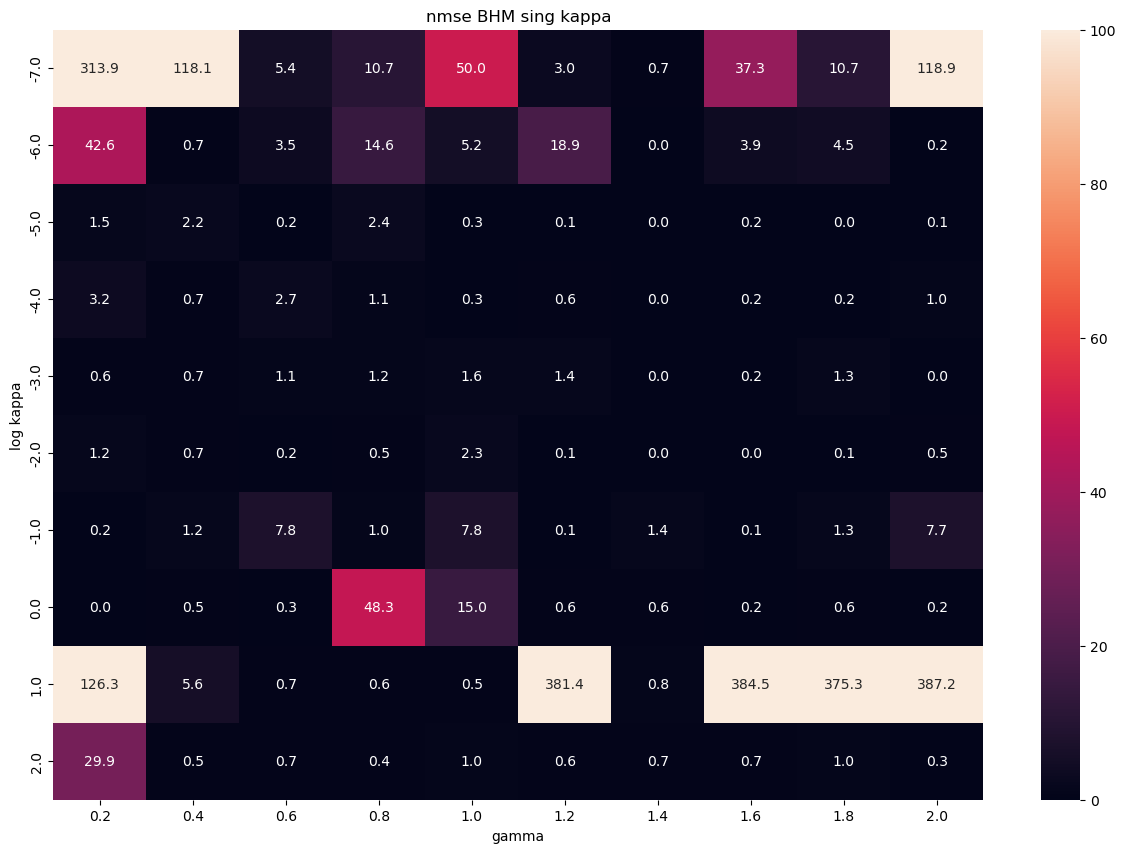

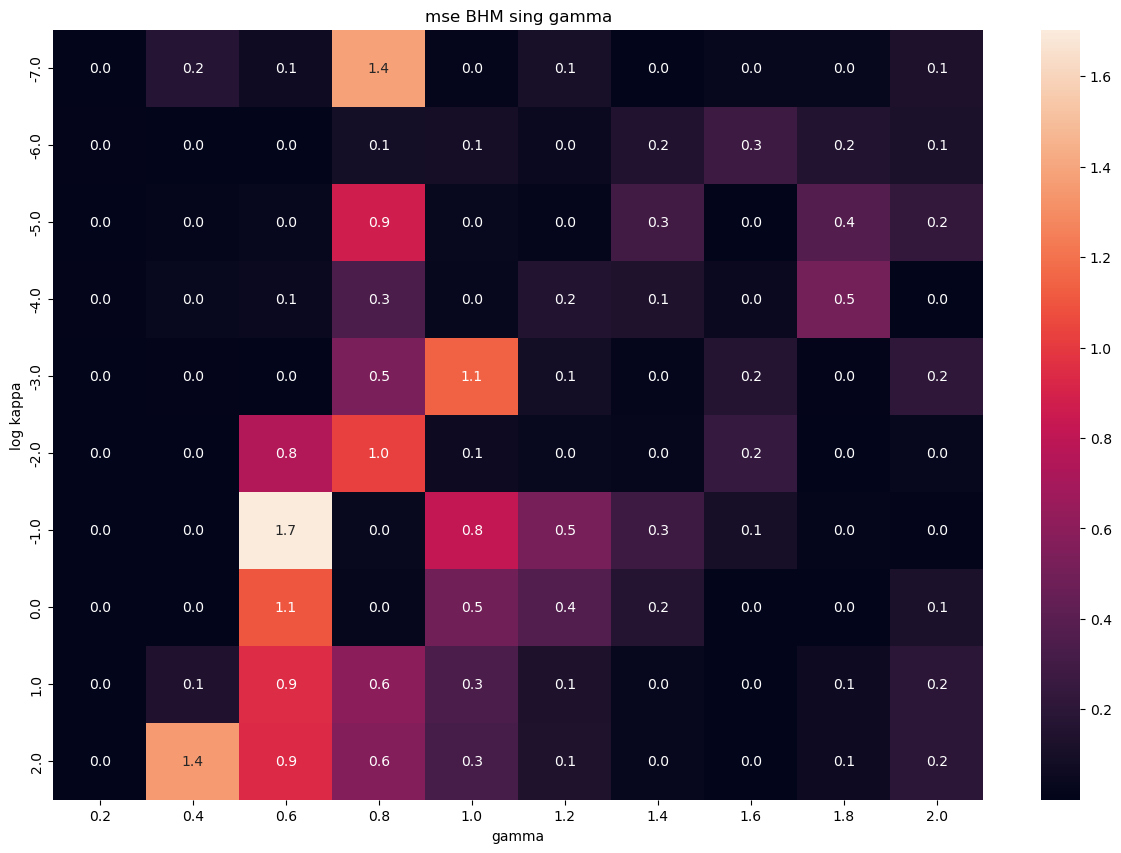

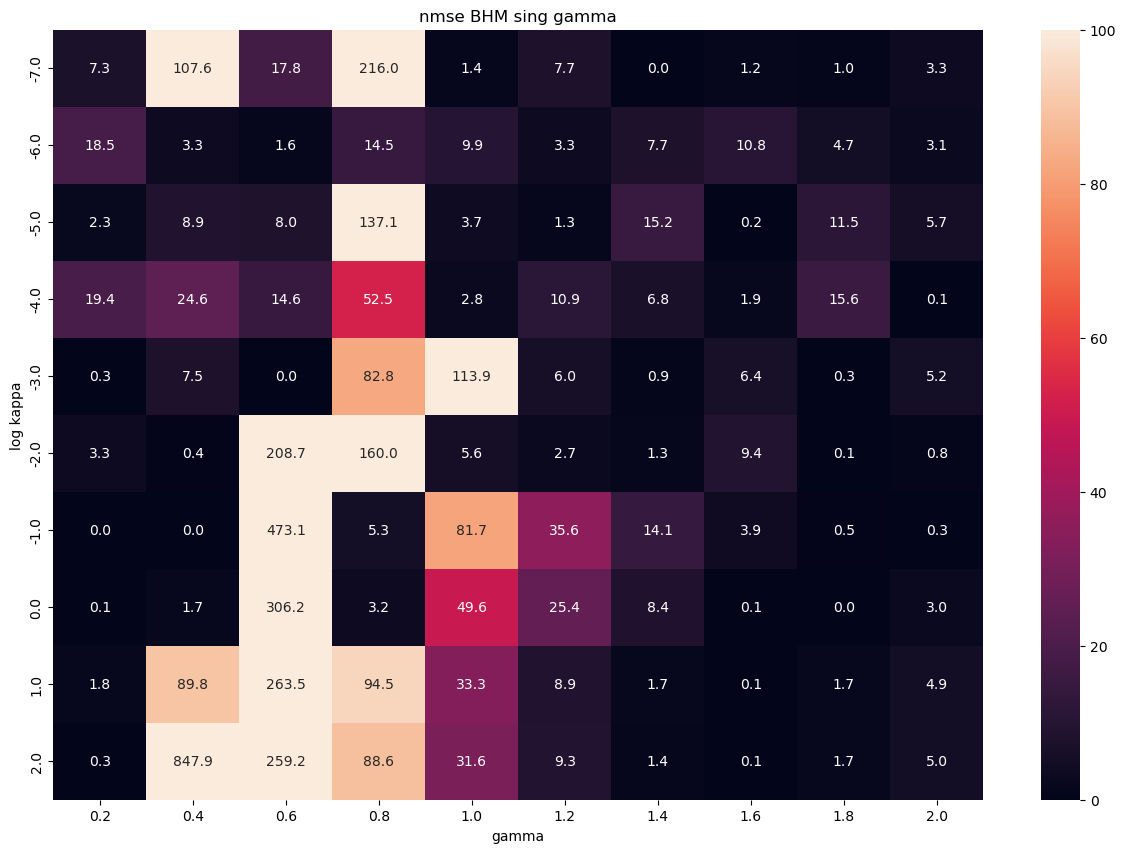

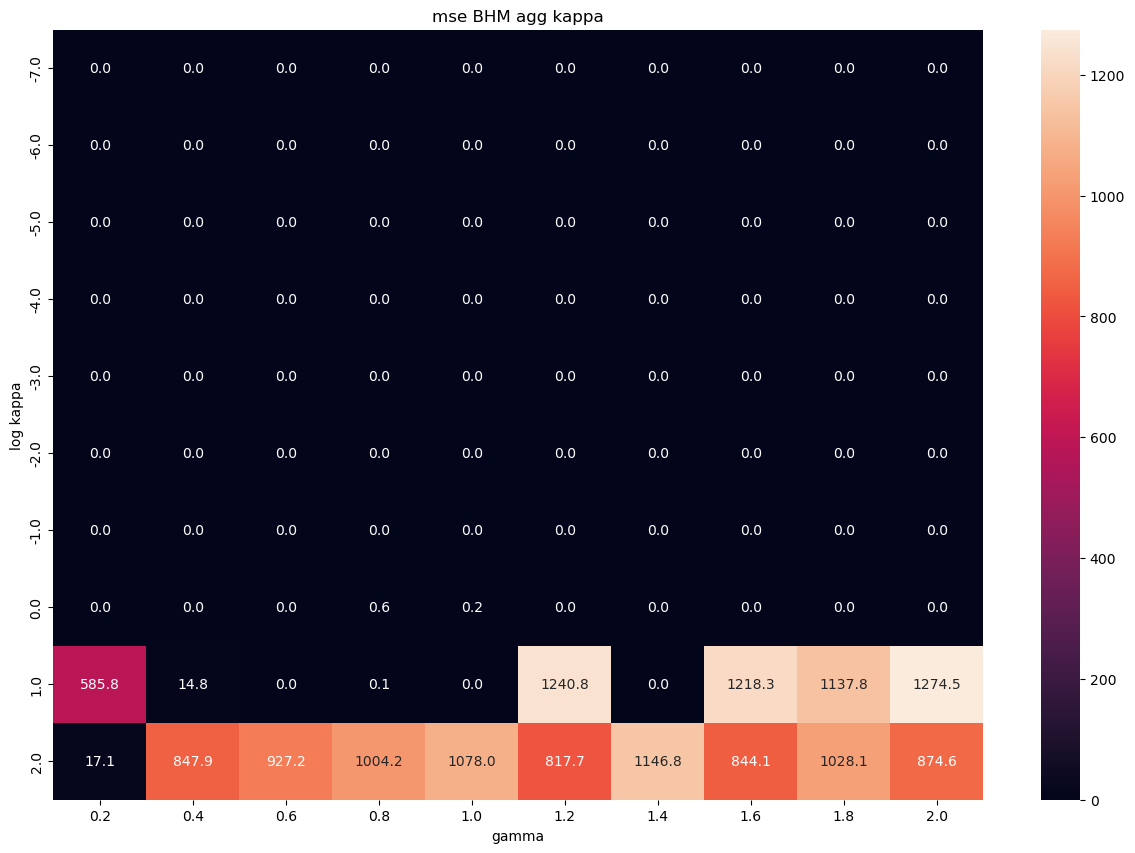

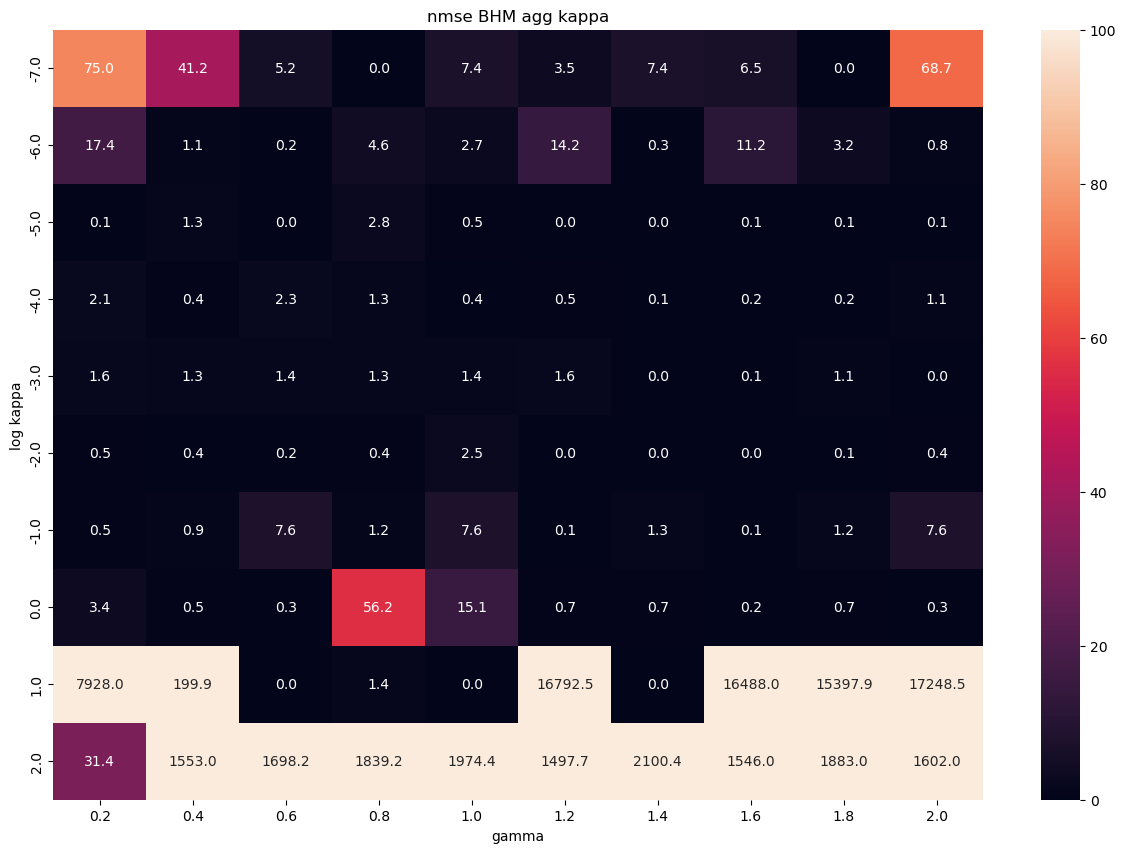

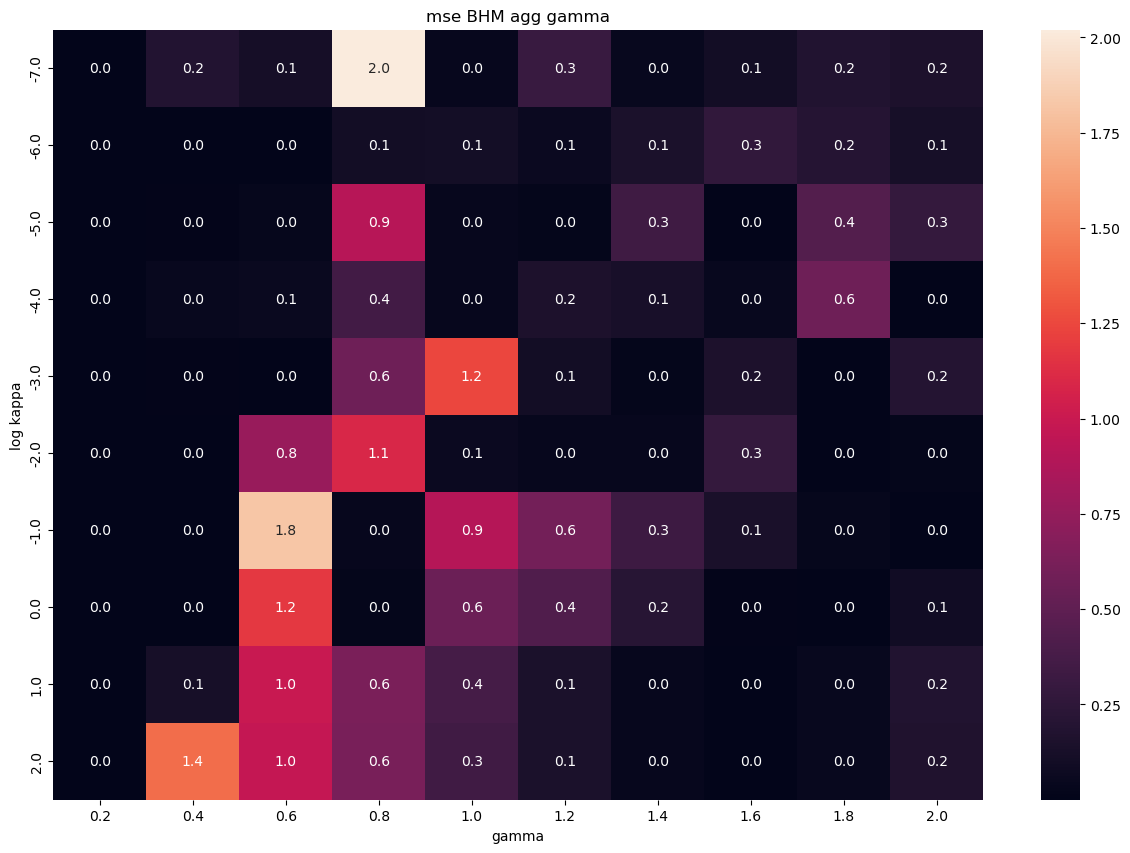

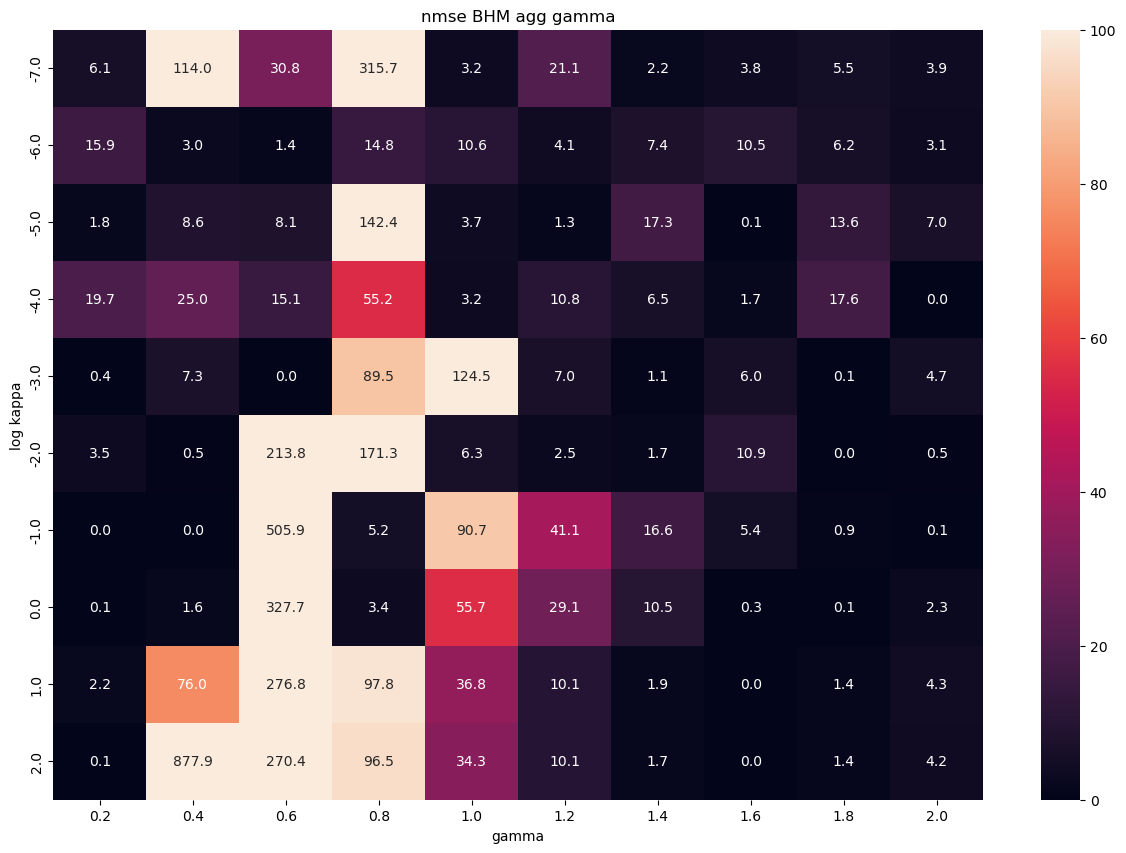

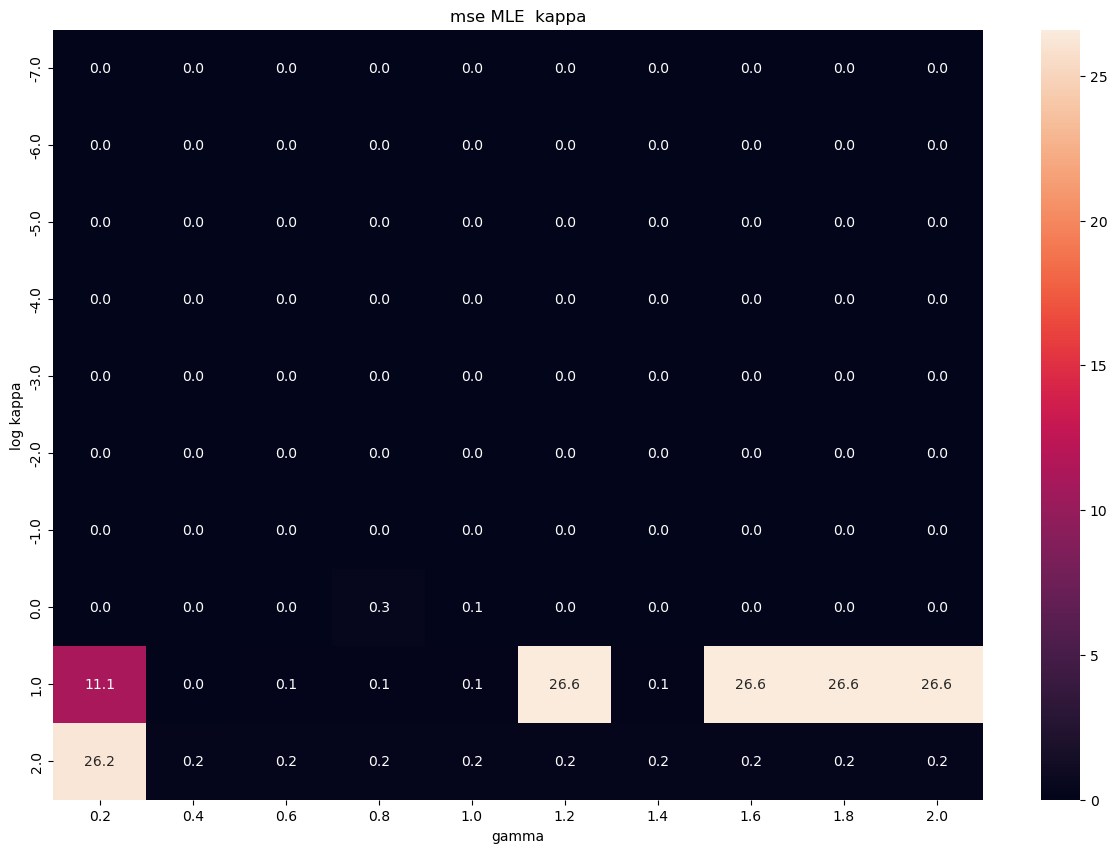

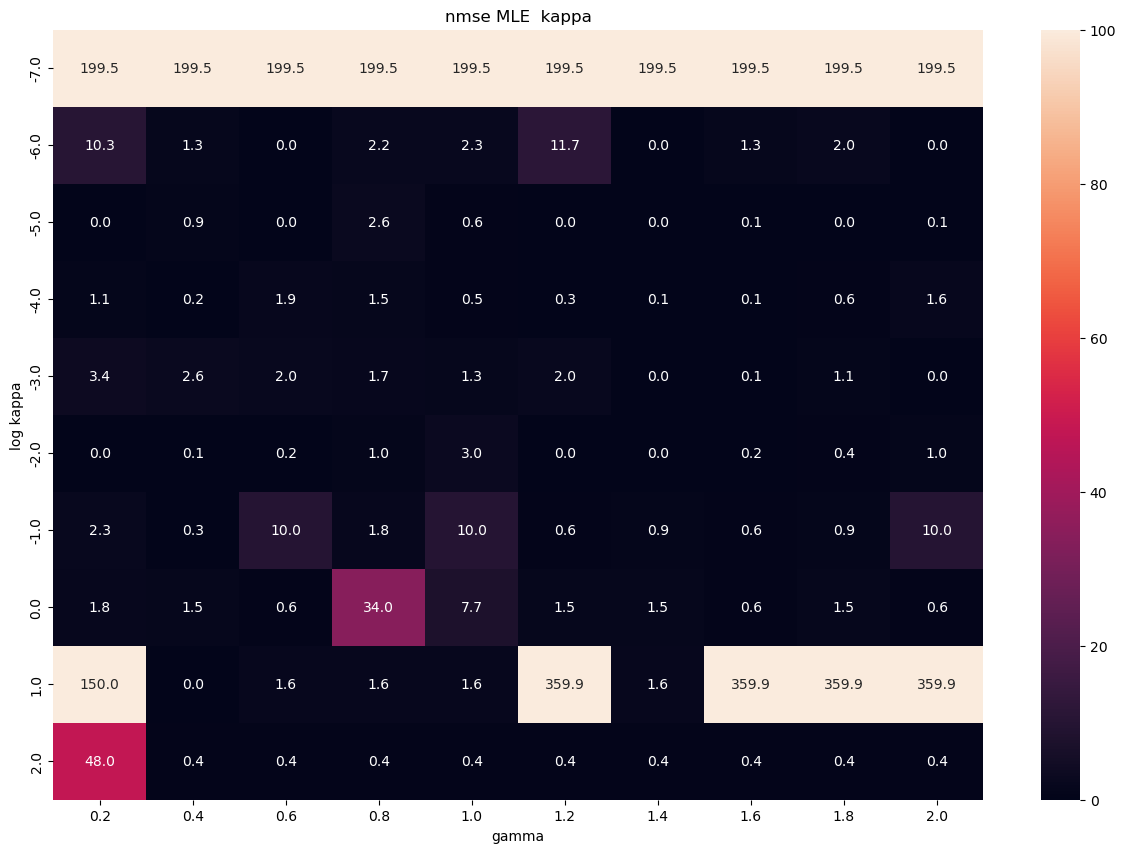

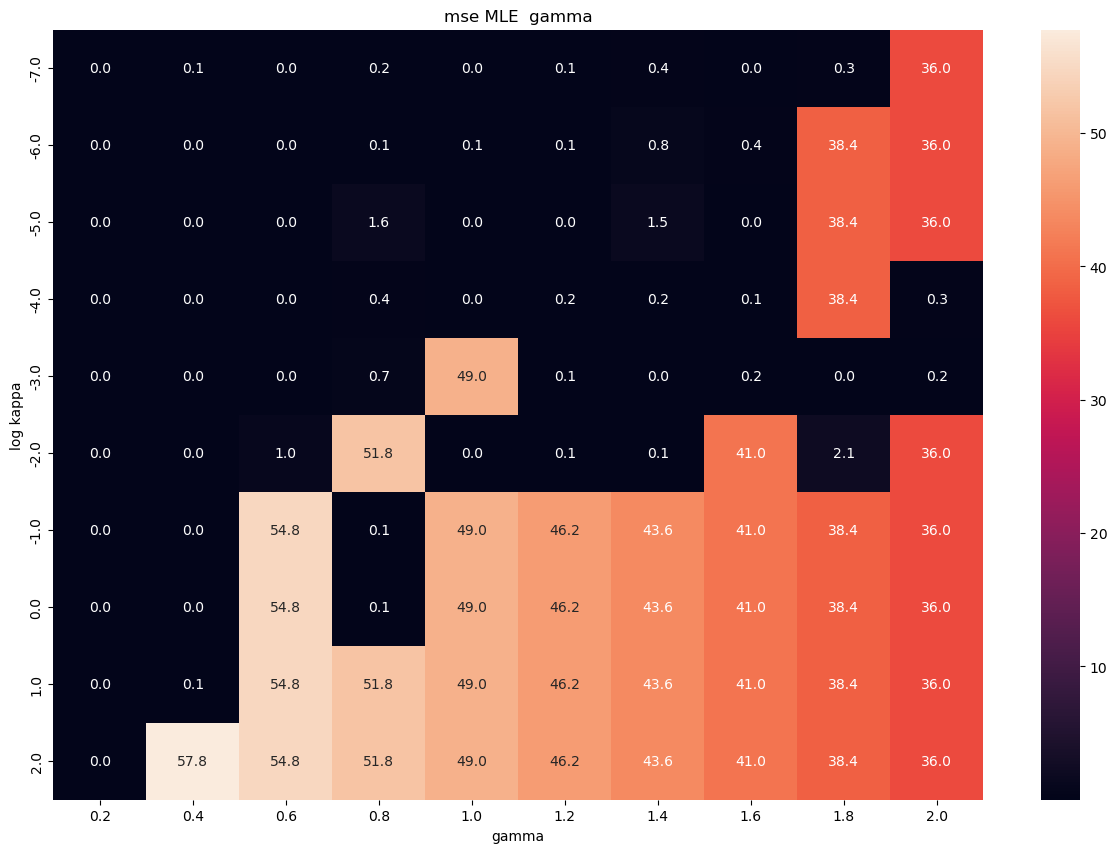

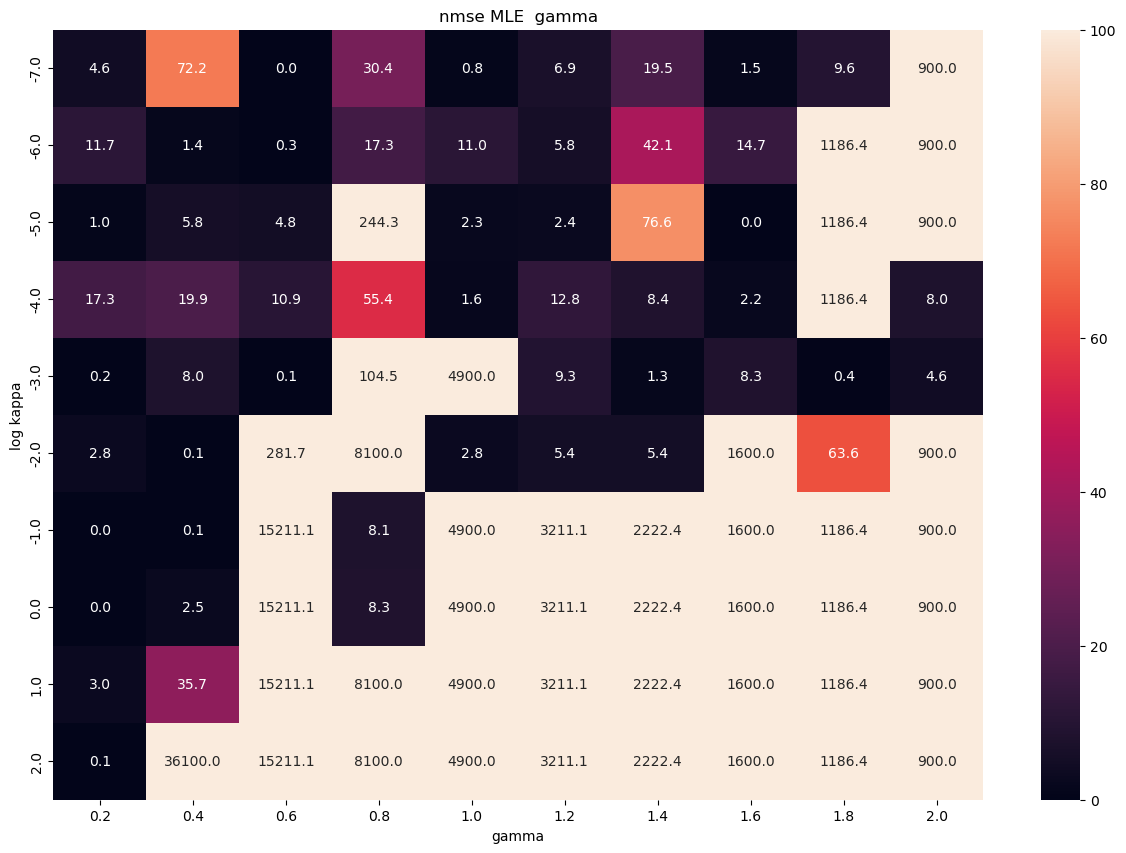

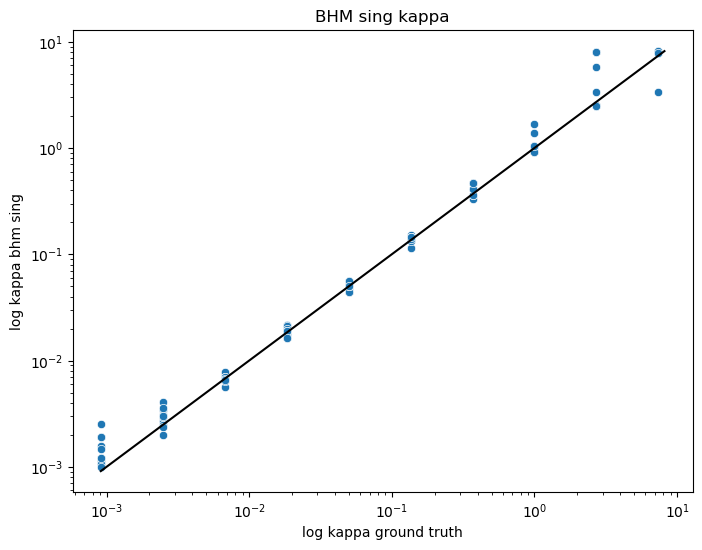

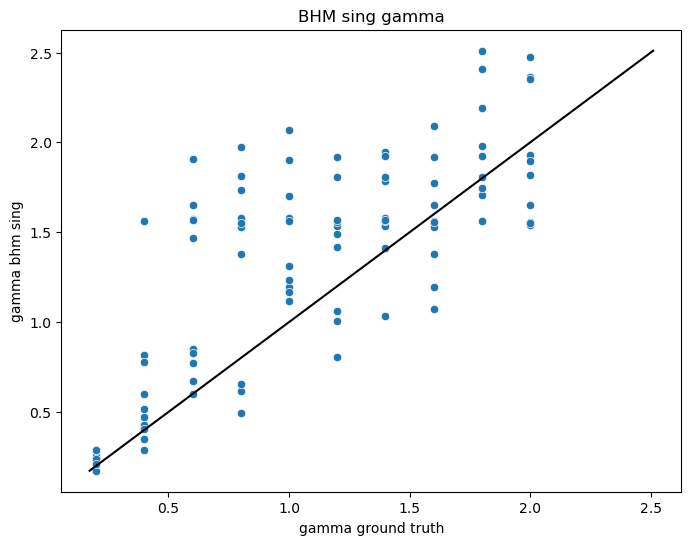

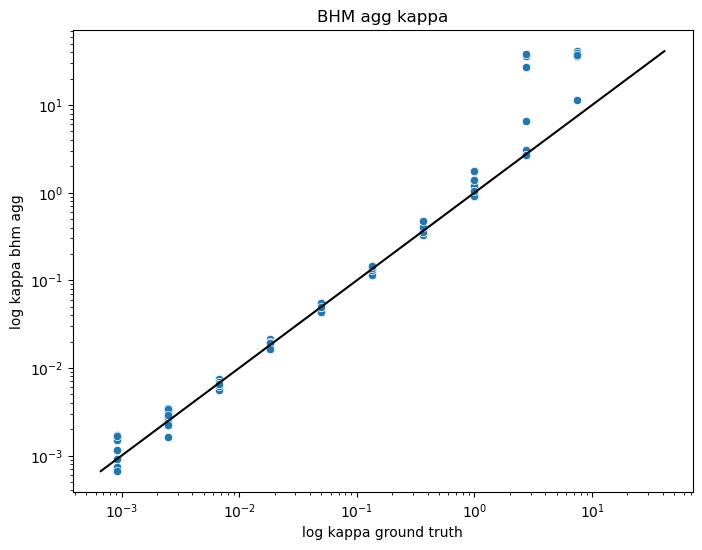

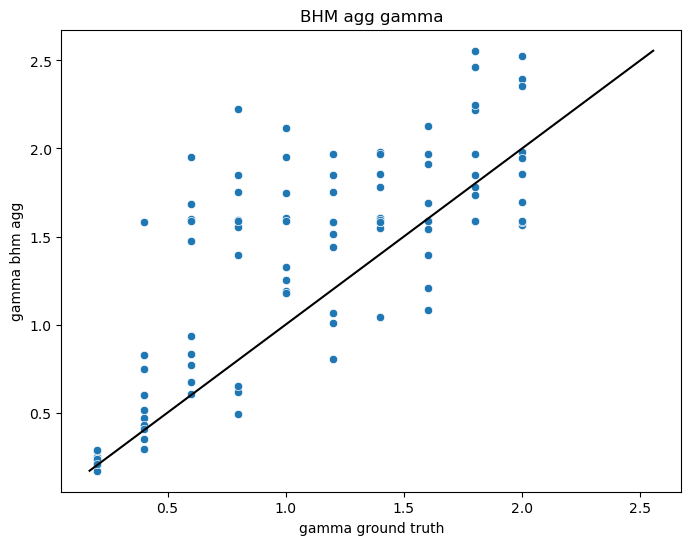

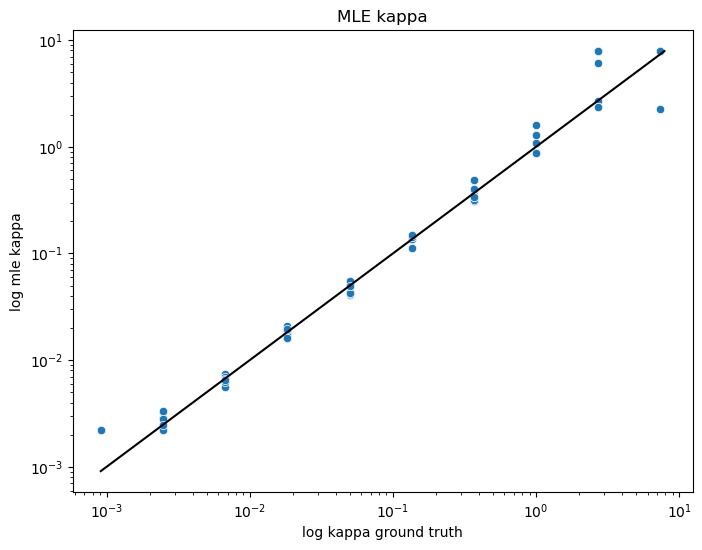

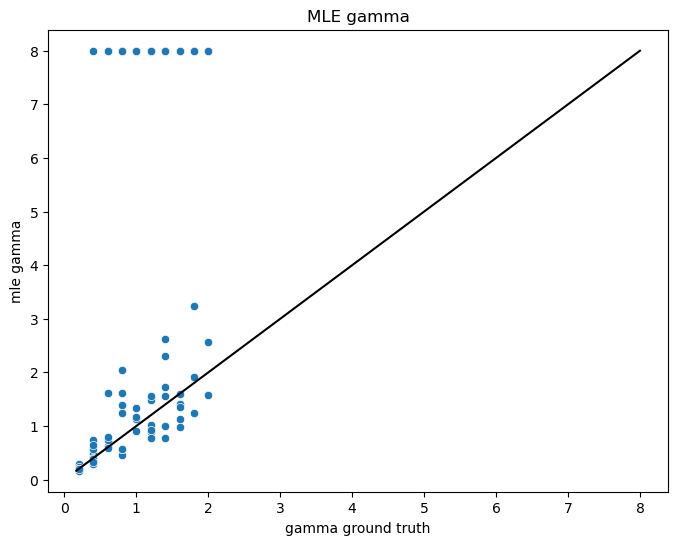

In [120]:

heatmap_save(bhm_df,model='bhm',type='sing')
heatmap_save(bhm_df,model='bhm',type='agg')
heatmap_save(mle_df,model='mle',type='')
# mle_df


scatter_plot(bhm_df,model='bhm',type='sing')
scatter_plot(bhm_df,model='bhm',type='agg')
scatter_plot(mle_df,model='mle',type='')
